# WeatherPy Analysis

## Question 
The fundamental question that we are trying to answer in this exercise is:
"What's the weather like as we approach the equator?"

## Objective
To visualize the weather of 500+ randomly selected cities across the world of varying distance from the equator. To build a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

## Technical Considerations
* Use python's library - [random](https://docs.python.org/3/library/random.html#), to generate the random city coordinates to be used. This will ensure that the coordinates are in fact not manually picked, but generated randomly
* Use a python library - [citipy](https://pypi.python.org/pypi/citipy), to get our list of cities from the randomly generated coordinates. This library will give us the nearest city for a given set of coordinates.
* Use the [OpenWeatherMap API](https://openweathermap.org/api) to get the weather data for all the cities that we get from our random coordinates
* Use Matplotlib libraries for Data Visualization

## Observations
From the plots in our analysis we see the following:
* Temperatures are higher on an average in the Southern Hemisphere and are lower in the Northern Hemisphere especially as we move away from the equator. Most cities in the southern hemisphere have temperatures above 50 deg F. Cities in the top 2/3rd of the Northern Hemisphere have temperatures in the range of -10 to 50 deg F.
* Cities near the equator have much higher temperatures than those away from the equator.
* There are a lot more cities with humidity in the 60% to 100% range around the globe. There are more cities in the southern hemisphere with higher humidity levels (80-100%).
* Most cities have wind speeds in the 0 to 20 mph range with more than half in the 0-10mph range.
* Cloudiness in cities is evenly distributed around the globe.

## Conclusion
Cities closer to the equator are hotter than cities away from the equator with more cities in the south of the equator being warmer. Proximity to the equator does not affect other factors like Humidity, Cloudiness or Wind Speed as much as it affects the Temperature

## Analysis Process
### Setting up the list of random cities around the globe
We use the citipy library to generate 150 random positive latitude numbers, negative latitude numbers, positive longitude numbers and negative longitude numbers. This will ensure that we have coordinate samples from all four quadrants of the globe. Furthermore we get random latitudes from two sections 0 to 45 and 45 to 90 in both hemispheres to ensure even distribution of latitudes close to and away from the equator. We generate more than 500 cities because we may not get weather data for some of them later.

In [196]:
# Import Dependencies
from citipy import citipy
import random
import requests as req
import json
import matplotlib.pyplot as plt
import pandas as pd
import time

In [197]:
# The API key for the OpenWeatherMap Api
api_key = "7e4ae0373bdeed043f36aeafca9fc7ff"

# The endpoint url for the api call to the OpenWeatherMap api
endpoint_url = "http://api.openweathermap.org/data/2.5/weather?q="

In [198]:
# Generate 150 random positive latitude numbers, negative latitude numbers, positive longitude numbers 
# and negative longitude numbers. This will ensure that we have coordinate samples from all four quadrants 
# of the globe. Furthermore we get random latitudes from two sections 0 to 45 and 45 to 90 to ensure even distribution
# of latitudes close to and away from the equator
pos_lats = [random.uniform(0, 45) for x in range(75)]
pos_lats += [random.uniform(45, 90) for x in range(75)]

neg_lats = [random.uniform(0, -45) for x in range(75)]
neg_lats += [random.uniform(-45, -90) for x in range(75)]

pos_lons = [random.uniform(0, 180) for x in range(150)]
neg_lons = [random.uniform(0, -180) for x in range(150)]

# List of coordinates for our cities
coords = []

# Create a combination of positive and negative latitides and longitudes to get our city coordinates
# This will give us a list of (150 * 4) = 600 coordinates
for i in range(150):
    coords.append((pos_lats[i], pos_lons[i]))
    coords.append((pos_lats[i], neg_lons[i]))
    coords.append((neg_lats[i], pos_lons[i]))
    coords.append((neg_lats[i], neg_lons[i]))

# Use the citipy library to get the nearest city for each of the set of coordinates generated above. 
# This should give us a list of 600 random cities along with their country codes
cities = [citipy.nearest_city(coord[0], coord[1]) for coord in coords]

In [199]:
# Create a city table with the city names and country codes that we have gathered above. We will add the 
# other weather information for these cities later
cities_df = pd.DataFrame(data = {"City Name": [city.city_name for city in cities],
                                "Country Code": [ city.country_code for city in cities]})

In [200]:
# Add columns for the remaining data for all the cities that we will collect
cities_df = pd.concat([cities_df,pd.DataFrame(columns=["City ID", "Latitude", "Longitude", "Temperature", "Pressure", "Humidity", "Cloudiness", "Wind Speed"])])

# Reorder the columns
cities_df = cities_df[["City ID", "City Name", "Country Code", "Latitude", "Longitude", "Temperature", "Pressure", "Humidity", "Cloudiness", "Wind Speed"]]

### A sneak peak at the data table with the cities and country codes populated.

In [201]:
cities_df.head()

,City ID,City Name,Country Code,Latitude,Longitude,Temperature,Pressure,Humidity,Cloudiness,Wind Speed
0,NaN,oum hadjer,td,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,san andres,co,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,grootfontein,na,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,marcona,pe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,nalut,ly,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting the weather data
We now loop through all the cities in our data frame and make an api call to the OpenWeatherMap Api. The Api Key we have allows for no more than 60 calls per minute. So after every 60 calls we pause for a  minute before moving to the next batch of 60 calls. If we get an error for any missing data for a city, we simply skip that city.

In [202]:
## Function that takes in the index value for the cities_df and for the city at that index, 
# gets the weather info via the api call and populates the respective columns at that index

def get_city_weather(index):
    city_str = cities_df.at[index, "City Name"] + "," + cities_df.at[index, "Country Code"]
    target_url = endpoint_url + city_str + "&units=imperial&appid=" + api_key
    
    print("Getting Data for %s with target_url = %s" %(city_str, target_url))
    city_response = req.get(target_url).json()

    # Get the information in a try block to ignore any cities that don't have all the information 
    try:
        cities_df.at[index, "City ID"] = city_response["id"]
        cities_df.at[index, "Latitude"] = city_response["coord"]["lat"]
        cities_df.at[index, "Longitude"] = city_response["coord"]["lon"]
        cities_df.at[index, "Temperature"] = city_response["main"]["temp"]
        cities_df.at[index, "Pressure"] = city_response["main"]["pressure"]
        cities_df.at[index, "Humidity"] = city_response["main"]["humidity"]
        cities_df.at[index, "Cloudiness"] = city_response["clouds"]["all"]
        cities_df.at[index, "Wind Speed"] = city_response["wind"]["speed"]
    except KeyError:
        print("Ignoring row at index " + str(index) + " due to Key Error for " + city_str)



In [203]:
# Get the weather data in batches of 60 cities as we have a limit of 60 per minute on api calls
for n in range(0,10):
    for row_index in range(n*60,(n*60)+60):
        get_city_weather(row_index)
    
    # Introduce a sleep time for just a minute for every 60th row because the OpenWeatherMap api has
    # a limit of no more than 60 requests in a minute. We do not need this after the last set.
    if n < 9:
        print("Wait for a minute. We've got data upto city index number : " + str(row_index))
        time.sleep(60)

Getting Data for oum hadjer,td with target_url = http://api.openweathermap.org/data/2.5/weather?q=oum hadjer,td&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for san andres,co with target_url = http://api.openweathermap.org/data/2.5/weather?q=san andres,co&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for grootfontein,na with target_url = http://api.openweathermap.org/data/2.5/weather?q=grootfontein,na&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for marcona,pe with target_url = http://api.openweathermap.org/data/2.5/weather?q=marcona,pe&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 3 due to Key Error for marcona,pe
Getting Data for nalut,ly with target_url = http://api.openweathermap.org/data/2.5/weather?q=nalut,ly&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for machico,pt with target_url = http://api.openweathermap.org/data/2.5/weather?q=machico,pt&units=imperial&appid

Ignoring row at index 50 due to Key Error for umzimvubu,za
Getting Data for avarua,ck with target_url = http://api.openweathermap.org/data/2.5/weather?q=avarua,ck&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for najran,sa with target_url = http://api.openweathermap.org/data/2.5/weather?q=najran,sa&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for pedernales,do with target_url = http://api.openweathermap.org/data/2.5/weather?q=pedernales,do&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for tsihombe,mg with target_url = http://api.openweathermap.org/data/2.5/weather?q=tsihombe,mg&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 54 due to Key Error for tsihombe,mg
Getting Data for valparaiso,cl with target_url = http://api.openweathermap.org/data/2.5/weather?q=valparaiso,cl&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for betare oya,cm with target_url = http://api.openweatherma

Getting Data for airai,pw with target_url = http://api.openweathermap.org/data/2.5/weather?q=airai,pw&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 100 due to Key Error for airai,pw
Getting Data for pinotepa nacional,mx with target_url = http://api.openweathermap.org/data/2.5/weather?q=pinotepa nacional,mx&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 101 due to Key Error for pinotepa nacional,mx
Getting Data for broken hill,au with target_url = http://api.openweathermap.org/data/2.5/weather?q=broken hill,au&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for pisco,pe with target_url = http://api.openweathermap.org/data/2.5/weather?q=pisco,pe&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for katsuura,jp with target_url = http://api.openweathermap.org/data/2.5/weather?q=katsuura,jp&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for dzilam gonzalez,mx with target_url = 

Getting Data for hilo,us with target_url = http://api.openweathermap.org/data/2.5/weather?q=hilo,us&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for esperance,au with target_url = http://api.openweathermap.org/data/2.5/weather?q=esperance,au&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for mataura,pf with target_url = http://api.openweathermap.org/data/2.5/weather?q=mataura,pf&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 151 due to Key Error for mataura,pf
Getting Data for porbandar,in with target_url = http://api.openweathermap.org/data/2.5/weather?q=porbandar,in&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for ponta do sol,cv with target_url = http://api.openweathermap.org/data/2.5/weather?q=ponta do sol,cv&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for hithadhoo,mv with target_url = http://api.openweathermap.org/data/2.5/weather?q=hithadhoo,mv&units=imperial&appid

Getting Data for samusu,ws with target_url = http://api.openweathermap.org/data/2.5/weather?q=samusu,ws&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 197 due to Key Error for samusu,ws
Getting Data for nguruka,tz with target_url = http://api.openweathermap.org/data/2.5/weather?q=nguruka,tz&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for samusu,ws with target_url = http://api.openweathermap.org/data/2.5/weather?q=samusu,ws&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 199 due to Key Error for samusu,ws
Getting Data for jalu,ly with target_url = http://api.openweathermap.org/data/2.5/weather?q=jalu,ly&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for codrington,ag with target_url = http://api.openweathermap.org/data/2.5/weather?q=codrington,ag&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 201 due to Key Error for codrington,ag
Getting Data for kang,bw with

Getting Data for halalo,wf with target_url = http://api.openweathermap.org/data/2.5/weather?q=halalo,wf&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 247 due to Key Error for halalo,wf
Getting Data for kampong chhnang,kh with target_url = http://api.openweathermap.org/data/2.5/weather?q=kampong chhnang,kh&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for ewa beach,us with target_url = http://api.openweathermap.org/data/2.5/weather?q=ewa beach,us&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for labuhan,id with target_url = http://api.openweathermap.org/data/2.5/weather?q=labuhan,id&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for samusu,ws with target_url = http://api.openweathermap.org/data/2.5/weather?q=samusu,ws&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 251 due to Key Error for samusu,ws
Getting Data for butaritari,ki with target_url = http://api.openweathe

Ignoring row at index 293 due to Key Error for port-de-paix,ht
Getting Data for waipawa,nz with target_url = http://api.openweathermap.org/data/2.5/weather?q=waipawa,nz&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for ancud,cl with target_url = http://api.openweathermap.org/data/2.5/weather?q=ancud,cl&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for hawalli,kw with target_url = http://api.openweathermap.org/data/2.5/weather?q=hawalli,kw&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 296 due to Key Error for hawalli,kw
Getting Data for tiznit,ma with target_url = http://api.openweathermap.org/data/2.5/weather?q=tiznit,ma&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for mogadishu,so with target_url = http://api.openweathermap.org/data/2.5/weather?q=mogadishu,so&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for harper,lr with target_url = http://api.openweathermap.org/data/2

Getting Data for chapais,ca with target_url = http://api.openweathermap.org/data/2.5/weather?q=chapais,ca&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for bluff,nz with target_url = http://api.openweathermap.org/data/2.5/weather?q=bluff,nz&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for ushuaia,ar with target_url = http://api.openweathermap.org/data/2.5/weather?q=ushuaia,ar&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for khonuu,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=khonuu,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Ignoring row at index 344 due to Key Error for khonuu,ru
Getting Data for pangnirtung,ca with target_url = http://api.openweathermap.org/data/2.5/weather?q=pangnirtung,ca&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for hobart,au with target_url = http://api.openweathermap.org/data/2.5/weather?q=hobart,au&units=imperial&appid=7e4ae0373bdeed04

Getting Data for dikson,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=dikson,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for barrow,us with target_url = http://api.openweathermap.org/data/2.5/weather?q=barrow,us&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for mahebourg,mu with target_url = http://api.openweathermap.org/data/2.5/weather?q=mahebourg,mu&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for vaini,to with target_url = http://api.openweathermap.org/data/2.5/weather?q=vaini,to&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for dikson,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=dikson,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for upernavik,gl with target_url = http://api.openweathermap.org/data/2.5/weather?q=upernavik,gl&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for saint-philippe,re with ta

Getting Data for kruisfontein,za with target_url = http://api.openweathermap.org/data/2.5/weather?q=kruisfontein,za&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for punta arenas,cl with target_url = http://api.openweathermap.org/data/2.5/weather?q=punta arenas,cl&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for vyazemskiy,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=vyazemskiy,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for dingle,ie with target_url = http://api.openweathermap.org/data/2.5/weather?q=dingle,ie&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for new norfolk,au with target_url = http://api.openweathermap.org/data/2.5/weather?q=new norfolk,au&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for cidreira,br with target_url = http://api.openweathermap.org/data/2.5/weather?q=cidreira,br&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Gettin

Getting Data for beringovskiy,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=beringovskiy,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for vestmannaeyjar,is with target_url = http://api.openweathermap.org/data/2.5/weather?q=vestmannaeyjar,is&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for kaitangata,nz with target_url = http://api.openweathermap.org/data/2.5/weather?q=kaitangata,nz&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for ushuaia,ar with target_url = http://api.openweathermap.org/data/2.5/weather?q=ushuaia,ar&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for vilyuysk,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=vilyuysk,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for norman wells,ca with target_url = http://api.openweathermap.org/data/2.5/weather?q=norman wells,ca&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7f

Getting Data for aklavik,ca with target_url = http://api.openweathermap.org/data/2.5/weather?q=aklavik,ca&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for dunedin,nz with target_url = http://api.openweathermap.org/data/2.5/weather?q=dunedin,nz&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for rikitea,pf with target_url = http://api.openweathermap.org/data/2.5/weather?q=rikitea,pf&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Wait for a minute. We've got data upto city index number : 539
Getting Data for darhan,mn with target_url = http://api.openweathermap.org/data/2.5/weather?q=darhan,mn&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for ucluelet,ca with target_url = http://api.openweathermap.org/data/2.5/weather?q=ucluelet,ca&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for albany,au with target_url = http://api.openweathermap.org/data/2.5/weather?q=albany,au&units=imperial&appid=7e4ae0373bde

Getting Data for beringovskiy,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=beringovskiy,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for chute-aux-outardes,ca with target_url = http://api.openweathermap.org/data/2.5/weather?q=chute-aux-outardes,ca&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for christchurch,nz with target_url = http://api.openweathermap.org/data/2.5/weather?q=christchurch,nz&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for rio gallegos,ar with target_url = http://api.openweathermap.org/data/2.5/weather?q=rio gallegos,ar&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for krutaya gorka,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=krutaya gorka,ru&units=imperial&appid=7e4ae0373bdeed043f36aeafca9fc7ff
Getting Data for provideniya,ru with target_url = http://api.openweathermap.org/data/2.5/weather?q=provideniya,ru&units=imperial&appid=7

### Data cleanup and a sneak peak at our final data
We now remove any rows that do not have some weather data. We also convert all the numeric columns to float for the visualizations

In [204]:
print("Total number of cities before dropping empty data: " + str(len(cities_df)))

Total number of cities before dropping empty data: 600


In [205]:
# Delete the rows with the cities that have no data
cities_df.dropna(inplace=True)
print("Total number of cities after dropping empty data: " + str(len(cities_df)))

Total number of cities after dropping empty data: 529


In [206]:
# Sneak peak at our data
cities_df.head()

,City ID,City Name,Country Code,Latitude,Longitude,Temperature,Pressure,Humidity,Cloudiness,Wind Speed
0,2426370,oum hadjer,td,13.3,19.7,86.27,971.63,46,8,3.27
1,7522928,san andres,co,8.22,-76.58,87.8,1013,58,20,13.87
2,3357114,grootfontein,na,-19.56,18.1,64.22,866.25,98,48,6.73
4,2214433,nalut,ly,31.86,10.98,56.66,959.07,60,68,5.5
5,2266895,machico,pt,32.7,-16.77,60.8,1008,67,75,2.24


In [207]:
# For our visualizations we will convert all the numeric columns to float
cities_df['Latitude'] = cities_df['Latitude'].astype(float)
cities_df['Longitude'] = cities_df['Longitude'].astype(float)
cities_df['Temperature'] = cities_df['Temperature'].astype(float)
cities_df['Pressure'] = cities_df['Pressure'].astype(float)
cities_df['Humidity'] = cities_df['Humidity'].astype(float)
cities_df['Cloudiness'] = cities_df['Cloudiness'].astype(float)
cities_df['Wind Speed'] = cities_df['Wind Speed'].astype(float)

cities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 0 to 599
Data columns (total 10 columns):
City ID         529 non-null object
City Name       529 non-null object
Country Code    529 non-null object
Latitude        529 non-null float64
Longitude       529 non-null float64
Temperature     529 non-null float64
Pressure        529 non-null float64
Humidity        529 non-null float64
Cloudiness      529 non-null float64
Wind Speed      529 non-null float64
dtypes: float64(7), object(3)
memory usage: 45.5+ KB


## Visualizations for the various weather parameters

### City Temperatures around the Globe
Visualization of the temperatures in cities across various latitudes

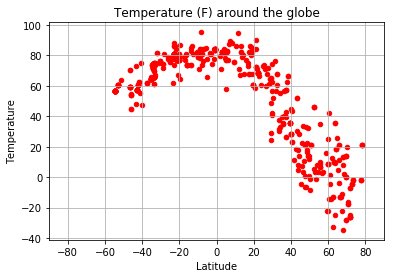

In [209]:
cities_df.plot(kind='scatter', x='Latitude', y='Temperature', color='r', title="Temperature (F) around the globe", grid=True, xlim=(-90,90))
plt.show()

### City Humidity levels around the Globe
Visualization of the humidity levels in cities across various latitudes

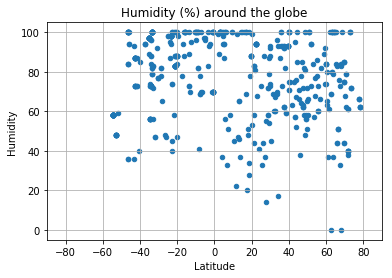

In [210]:
cities_df.plot(kind='scatter', x='Latitude', y='Humidity', title="Humidity (%) around the globe", grid=True, xlim=(-90,90))
plt.show()

### Wind Speeds in cities around the Globe
Visualization of the wind speeds in cities across various latitudes

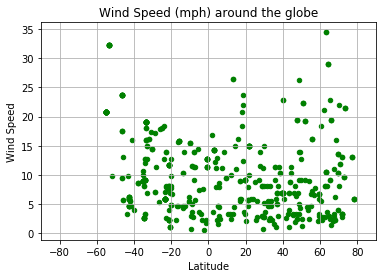

In [211]:
cities_df.plot(kind='scatter', x='Latitude', y='Wind Speed', color='g', title="Wind Speed (mph) around the globe", grid=True, xlim=(-90,90))
plt.show()

### Cloudiness in cities around the Globe
Visualization of the cloudiness in cities across various latitudes

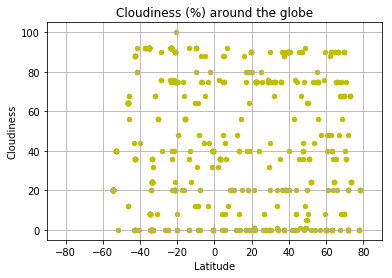

In [212]:
cities_df.plot(kind='scatter', x='Latitude', y='Cloudiness', color='y', title="Cloudiness (%) around the globe", grid=True, xlim=(-90,90))
plt.show()